# **Challenge:**

Using the [BestBuyAPIs](https://github.com/BestBuyAPIs/open-data-set) dataset, We are building an API with one endpoint that receives the **name** and **description** of a new product as input parameters, and outputs the **categories** that this new product should be in.



1.   Data understanding
2.   Features preprocessing
3. Labels encoding
4. Classifier building
3. API building



In [ ]:
import nltk 
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('stopwords')
nltk.download('punkt')


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, hamming_loss

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Data understanding

In [ ]:
df = pd.read_json('/content/gdrive/MyDrive/products.json')

In [ ]:
df.head()

,sku,name,type,price,upc,category,shipping,description,manufacturer,model,url,image
0,43900,Duracell - AAA Batteries (4-Pack),HardGood,5.49,41333424019,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",5.49,Compatible with select electronic devices; AAA...,Duracell,MN2400B4Z,http://www.bestbuy.com/site/duracell-aaa-batte...,http://img.bbystatic.com/BestBuy_US/images/pro...
1,48530,Duracell - AA 1.5V CopperTop Batteries (4-Pack),HardGood,5.49,41333415017,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",5.49,Long-lasting energy; DURALOCK Power Preserve t...,Duracell,MN1500B4Z,http://www.bestbuy.com/site/duracell-aa-1-5v-c...,http://img.bbystatic.com/BestBuy_US/images/pro...
2,127687,Duracell - AA Batteries (8-Pack),HardGood,7.49,41333825014,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",5.49,Compatible with select electronic devices; AA ...,Duracell,MN1500B8Z,http://www.bestbuy.com/site/duracell-aa-batter...,http://img.bbystatic.com/BestBuy_US/images/pro...
3,150115,Energizer - MAX Batteries AA (4-Pack),HardGood,4.99,39800011329,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",5.49,4-pack AA alkaline batteries; battery tester i...,Energizer,E91BP-4,http://www.bestbuy.com/site/energizer-max-batt...,http://img.bbystatic.com/BestBuy_US/images/pro...
4,185230,Duracell - C Batteries (4-Pack),HardGood,8.99,41333440019,"[{'id': 'pcmcat312300050015', 'name': 'Connect...",5.49,Compatible with select electronic devices; C s...,Duracell,MN1400R4Z,http://www.bestbuy.com/site/duracell-c-batteri...,http://img.bbystatic.com/BestBuy_US/images/pro...


In [ ]:
df.tail()

,sku,name,type,price,upc,category,shipping,description,manufacturer,model,url,image
51641,9995663,Honeywell - True HEPA Replacement Filters for ...,HardGood,49.99,92926500023,"[{'id': 'abcat0900000', 'name': 'Appliances'},...",0,Compatible with select Honeywell air purifier ...,Honeywell,HRF-N2,http://www.bestbuy.com/site/honeywell-true-hep...,http://img.bbystatic.com/BestBuy_US/images/pro...
51642,9996238,Dyson - Hard Floor Wipes for Dyson Hard DC56 V...,HardGood,6.99,879957008960,"[{'id': 'abcat0900000', 'name': 'Appliances'},...",5.99,Removes dirt and grime from hard floors; cloth...,Dyson,965383-01,http://www.bestbuy.com/site/dyson-hard-floor-w...,http://img.bbystatic.com/BestBuy_US/images/pro...
51643,9996826,Aleratec - Drive Enclosure - Internal - Black,HardGood,35.99,808068004295,"[{'id': 'abcat0500000', 'name': 'Computers & T...",0,"1 x Total Bay - 1 x 2.5"" Bay",Aleratec,350106,http://www.bestbuy.com/site/aleratec-drive-enc...,http://img.bbystatic.com/BestBuy_US/images/pro...
51644,9999119,Amazon - Fire TV Stick,HardGood,39.99,848719037869,"[{'id': 'abcat0100000', 'name': 'TV & Home The...",0,"Streams 1080p content; dual-band, dual-antenna...",Amazon,53-002444,http://www.bestbuy.com/site/amazon-fire-tv-sti...,http://img.bbystatic.com/BestBuy_US/images/pro...
51645,9999678,Proctor Silex - 4-Slice Toaster Oven - White,HardGood,25.99,22333311165,"[{'id': 'abcat0900000', 'name': 'Appliances'},...",9.49,"PROCTOR SILEX 4-Slice Toaster Oven: Bake, broi...",Proctor Silex,31116R,http://www.bestbuy.com/site/proctor-silex-4-sl...,http://img.bbystatic.com/BestBuy_US/images/pro...


In [ ]:
df.shape

(51646, 12)

In [ ]:
df.columns

Index(['sku', 'name', 'type', 'price', 'upc', 'category', 'shipping',
       'description', 'manufacturer', 'model', 'url', 'image'],
      dtype='object')

In [ ]:
df['name'].unique()

array(['Duracell - AAA Batteries (4-Pack)',
       'Duracell - AA 1.5V CopperTop Batteries (4-Pack)',
       'Duracell - AA Batteries (8-Pack)', ...,
       'Aleratec - Drive Enclosure - Internal - Black',
       'Amazon - Fire TV Stick',
       'Proctor Silex - 4-Slice Toaster Oven - White'], dtype=object)

In [ ]:
df['name'].value_counts()

Lenmar - Lithium-Ion Battery - Black                                                         31
DigiPower - Lithium-Ion Battery - Black                                                      20
Ultralast - Lithium-Ion Battery for Select LG Cell Phones - White/Black                      19
Ultralast - Lithium-Ion Battery for Select Samsung Cell Phones - Multi                       19
DigiPower - Rechargeable Lithium-Ion Battery - Black                                         17
                                                                                             ..
Electrolux - Laundry Pedestal with Storage Drawer - Gray                                      1
Frigidaire - 7.0 Cu. Ft. 10-Cycle Electric Dryer with Steam - Classic Silver                  1
Electrolux - 4.2 Cu. Ft. 11-Cycle High-Efficiency Front-Loading Washer - White                1
Frigidaire - 3.9 Cu. Ft. High-Efficiency Front-Loading Washer with Steam - Classic Silver     1
Proctor Silex - 4-Slice Toaster Oven - W

In [ ]:
df['description'].value_counts()

Perfect gift card? Piece of cake. All Best Buy gift cards are shipped free and are good toward future purchases online and in U.S. or Puerto Rico Best Buy stores. Best Buy gift cards do not have an expiration date.                                                         370
Drive evil crazy to save Skylands                                                                                                                                                                                                                                               37
Android 5.0 Lollipop operating system4G LTE speedWi-Fi5.1" Super AMOLED touch screenBluetooth enabled                                                                                                                                                                           36
4.7-inch Retina HD displayA9 chip with 64-bit desktop-class architectureNew 12MP iSight camera with Live Photos3D TouchiOS and iCloud7.1mm thin, seamless design               

In [ ]:
df = df.drop_duplicates(subset=['name', 'description'])
df.shape

(50966, 12)

We remove duplicates, cause in case of nonrandom sampling, they can bias the fitted model. Including them will essentially lead to the model overfitting this subset of points.

In [ ]:
df['category'].values

array([list([{'id': 'pcmcat312300050015', 'name': 'Connected Home & Housewares'}, {'id': 'pcmcat248700050021', 'name': 'Housewares'}, {'id': 'pcmcat303600050001', 'name': 'Household Batteries'}, {'id': 'abcat0208002', 'name': 'Alkaline Batteries'}]),
       list([{'id': 'pcmcat312300050015', 'name': 'Connected Home & Housewares'}, {'id': 'pcmcat248700050021', 'name': 'Housewares'}, {'id': 'pcmcat303600050001', 'name': 'Household Batteries'}, {'id': 'abcat0208002', 'name': 'Alkaline Batteries'}]),
       list([{'id': 'pcmcat312300050015', 'name': 'Connected Home & Housewares'}, {'id': 'pcmcat248700050021', 'name': 'Housewares'}, {'id': 'pcmcat303600050001', 'name': 'Household Batteries'}, {'id': 'abcat0208002', 'name': 'Alkaline Batteries'}]),
       ...,
       list([{'id': 'abcat0500000', 'name': 'Computers & Tablets'}, {'id': 'abcat0515000', 'name': 'Computer Accessories & Peripherals'}, {'id': 'abcat0504001', 'name': 'Hard Drives & Storage'}, {'id': 'pcmcat186100050005', 'name': 'Ex

In [ ]:
df['category'].values[1]

[{'id': 'pcmcat312300050015', 'name': 'Connected Home & Housewares'},
 {'id': 'pcmcat248700050021', 'name': 'Housewares'},
 {'id': 'pcmcat303600050001', 'name': 'Household Batteries'},
 {'id': 'abcat0208002', 'name': 'Alkaline Batteries'}]

Each simple belongs to one or more class labels: We are dealing with **Multi-label classification**.

The only relevant attributes for our problem set are name, description, and category.

In [ ]:
df = df[['name','description','category']]

In [ ]:
# Check missing values
df.isnull().sum()

name           1
description    0
category       0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.shape

(50965, 3)

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)

In [ ]:
df.head()

,name,description,category
14162,OtterBox - Defender Series Holster Case for Sa...,Crafted for Samsung Galaxy Note 5 cell phones;...,"[{'id': 'abcat0800000', 'name': 'Cell Phones'}..."
9451,Case Logic - Travel Wallet - Black,Magnetic closure; ID window; 8 credit card slo...,"[{'id': 'pcmcat312300050015', 'name': 'Connect..."
22150,Incipio - DualPro Glitter Case for Apple® iPho...,INCIPIO DualPro Glitter Case for Apple iPhone ...,"[{'id': 'abcat0800000', 'name': 'Cell Phones'}..."
41229,Nest - Protect 2nd Generation Smart Smoke/Carb...,"Connects to compatible devices via 3G, 4G, 4G ...","[{'id': 'pcmcat312300050015', 'name': 'Connect..."
37474,Whirlpool - Gold 1.4 Cu. Ft. Convertible Trash...,Touch-Toe drawer opener; Clean Touch console; ...,"[{'id': 'abcat0900000', 'name': 'Appliances'},..."


In [ ]:
features_df = df[['name','description']]
Labels_df = df[['category']]

# Features Dataframe

In [ ]:
features_df.head()

,name,description
14162,OtterBox - Defender Series Holster Case for Sa...,Crafted for Samsung Galaxy Note 5 cell phones;...
9451,Case Logic - Travel Wallet - Black,Magnetic closure; ID window; 8 credit card slo...
22150,Incipio - DualPro Glitter Case for Apple® iPho...,INCIPIO DualPro Glitter Case for Apple iPhone ...
41229,Nest - Protect 2nd Generation Smart Smoke/Carb...,"Connects to compatible devices via 3G, 4G, 4G ..."
37474,Whirlpool - Gold 1.4 Cu. Ft. Convertible Trash...,Touch-Toe drawer opener; Clean Touch console; ...


## Features cleaning:

[Text Cleaning Methods](https://towardsdatascience.com/text-cleaning-methods-for-natural-language-processing-f2fc1796e8c7)

To clean both "name" and "description" columns, we create a function and then apply it to the dataset:

In [ ]:

def  clean_text(df, text_field, new_text_field_name):
    
    # 1. remove punctuation:
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  

    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))

    # removing stop words with NLTK  
    stop = stopwords.words('english')
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    """
    Stemming is the process of reducing words to their root form. Before we can perform stemming on our data we need
    to tokenise the text. This is a method used to split the text into its constituent words.
    """
    # Stemming
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_tokenize(x))

    # The code below uses the PorterStemmer method from NLTK to apply 
    # stemming to the text_tokens and outputs the processed text to a new column.
    def word_stemmer(text):
        stem_text = [PorterStemmer().stem(i) for i in text]
        s_text = ' '.join(stem_text)
        return s_text
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_stemmer(x))

    return df

data_clean = clean_text(features_df, 'name', 'name_clean')
data_clean = clean_text(features_df, 'description', 'description_clean')

data_clean.head()


,name,description,name_clean,description_clean
14162,OtterBox - Defender Series Holster Case for Sa...,Crafted for Samsung Galaxy Note 5 cell phones;...,otterbox defend seri holster case samsung gala...,craft samsung galaxi note cell phone polycarbo...
9451,Case Logic - Travel Wallet - Black,Magnetic closure; ID window; 8 credit card slo...,case logic travel wallet black,magnet closur id window credit card slot slip ...
22150,Incipio - DualPro Glitter Case for Apple® iPho...,INCIPIO DualPro Glitter Case for Apple iPhone ...,incipio dualpro glitter case appl iphon purpl,incipio dualpro glitter case appl iphon compat...
41229,Nest - Protect 2nd Generation Smart Smoke/Carb...,"Connects to compatible devices via 3G, 4G, 4G ...",nest protect nd gener smart smokecarbon monoxi...,connect compat devic via g g g lte bluetooth s...
37474,Whirlpool - Gold 1.4 Cu. Ft. Convertible Trash...,Touch-Toe drawer opener; Clean Touch console; ...,whirlpool gold cu ft convert trash compactor w...,touchto drawer open clean touch consol automat...


[Stemming vs Lemmatization](https://towardsdatascience.com/stemming-vs-lemmatization-2daddabcb221)

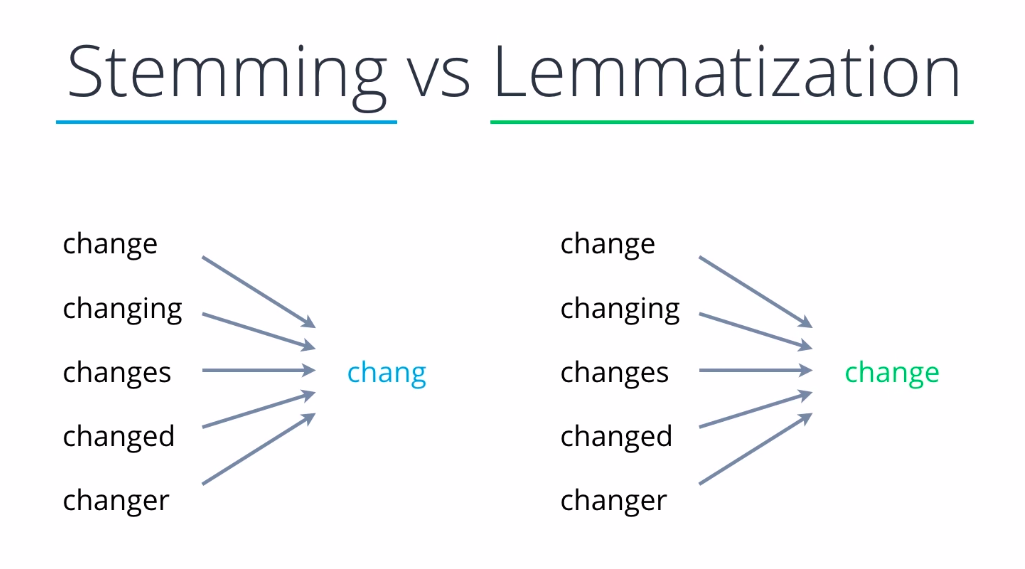

The goal of lemmatization is the same as for stemming, in that it aims to reduce words to their root form. However, stemming is known to be a fairly crude method of doing this. Lemmatization, on the other hand, is a tool that performs full morphological analysis to more accurately find the root, or “lemma” for a word.

In [ ]:
data_clean = data_clean[['name_clean', 'description_clean']]

## Features pre-processing:

[TF-IDF](https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275)

[TF-IDF choice](https://www.analyticsvidhya.com/blog/2021/06/part-5-step-by-step-guide-to-master-nlp-text-vectorization-approaches/)

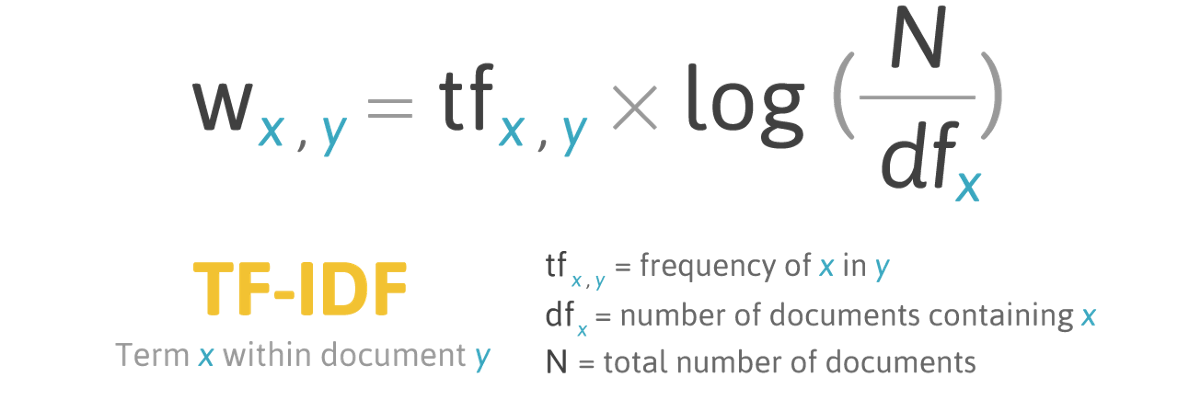

**TF-IDF** is a statistic that aims to better define how important a word is for a document, while also taking into account the relation to other documents from the same corpus.

**TFIDFVectorizer**

With Tfidfvectorizer, you will do all three steps at once. Under the hood, it computes the word counts, idf values, and tfidf scores all using the same dataset.

In [ ]:
v = TfidfVectorizer() #vectorizer
X = v.fit_transform(data_clean['name_clean'] + data_clean['description_clean'])

In [ ]:
np.asarray(X)

array(<50965x40212 sparse matrix of type '<class 'numpy.float64'>'
	with 876990 stored elements in Compressed Sparse Row format>,
      dtype=object)

# Labels DataFrame

## Labels cleaning:

In [ ]:
Labels_df

,category
14162,"[{'id': 'abcat0800000', 'name': 'Cell Phones'}..."
9451,"[{'id': 'pcmcat312300050015', 'name': 'Connect..."
22150,"[{'id': 'abcat0800000', 'name': 'Cell Phones'}..."
41229,"[{'id': 'pcmcat312300050015', 'name': 'Connect..."
37474,"[{'id': 'abcat0900000', 'name': 'Appliances'},..."
...,...
5888,"[{'id': 'abcat0300000', 'name': 'Car Electroni..."
19026,"[{'id': 'abcat0900000', 'name': 'Appliances'},..."
39041,"[{'id': 'abcat0200000', 'name': 'Audio'}, {'id..."
17872,"[{'id': 'abcat0900000', 'name': 'Appliances'},..."


In [ ]:
Labels_df['category'].values

array([list([{'id': 'abcat0800000', 'name': 'Cell Phones'}, {'id': 'abcat0811002', 'name': 'Cell Phone Accessories'}, {'id': 'abcat0811006', 'name': 'Cell Phone Cases & Clips'}]),
       list([{'id': 'pcmcat312300050015', 'name': 'Connected Home & Housewares'}, {'id': 'pcmcat341100050005', 'name': 'Household Essentials'}, {'id': 'pcmcat253700050018', 'name': 'Luggage, Bags & Travel'}, {'id': 'pcmcat271700050005', 'name': 'Travel Accessories'}, {'id': 'pcmcat271700050007', 'name': 'Travel Wallets'}]),
       list([{'id': 'abcat0800000', 'name': 'Cell Phones'}, {'id': 'abcat0811002', 'name': 'Cell Phone Accessories'}, {'id': 'pcmcat191200050015', 'name': 'iPhone Accessories'}, {'id': 'pcmcat214700050000', 'name': 'iPhone Cases & Clips'}, {'id': 'pcmcat748300580023', 'name': 'iPhone 6s Cases'}]),
       ...,
       list([{'id': 'abcat0200000', 'name': 'Audio'}, {'id': 'pcmcat310200050004', 'name': 'Bluetooth & Wireless Speakers'}]),
       list([{'id': 'abcat0900000', 'name': 'Appliances'

In [ ]:
Labels_df['category_name'] = df['category'].apply(lambda L: [l['name'] for l in L])
Labels_df['category_id'] = df['category'].apply(lambda L: [l['id'] for l in L] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
Labels_df.head()

,category,category_name,category_id
14162,"[{'id': 'abcat0800000', 'name': 'Cell Phones'}...","[Cell Phones, Cell Phone Accessories, Cell Pho...","[abcat0800000, abcat0811002, abcat0811006]"
9451,"[{'id': 'pcmcat312300050015', 'name': 'Connect...","[Connected Home & Housewares, Household Essent...","[pcmcat312300050015, pcmcat341100050005, pcmca..."
22150,"[{'id': 'abcat0800000', 'name': 'Cell Phones'}...","[Cell Phones, Cell Phone Accessories, iPhone A...","[abcat0800000, abcat0811002, pcmcat19120005001..."
41229,"[{'id': 'pcmcat312300050015', 'name': 'Connect...","[Connected Home & Housewares, Connected Home]","[pcmcat312300050015, pcmcat254000050002]"
37474,"[{'id': 'abcat0900000', 'name': 'Appliances'},...","[Appliances, Appliance Parts & Accessories, Tr...","[abcat0900000, abcat0916000, abcat0906001]"


In [ ]:
Labels_df['nb_categories'] = Labels_df['category_name'].apply(lambda L: len(L) )

In [ ]:
Labels_df.head()

,category,category_name,category_id,nb_categories
14162,"[{'id': 'abcat0800000', 'name': 'Cell Phones'}...","[Cell Phones, Cell Phone Accessories, Cell Pho...","[abcat0800000, abcat0811002, abcat0811006]",3
9451,"[{'id': 'pcmcat312300050015', 'name': 'Connect...","[Connected Home & Housewares, Household Essent...","[pcmcat312300050015, pcmcat341100050005, pcmca...",5
22150,"[{'id': 'abcat0800000', 'name': 'Cell Phones'}...","[Cell Phones, Cell Phone Accessories, iPhone A...","[abcat0800000, abcat0811002, pcmcat19120005001...",5
41229,"[{'id': 'pcmcat312300050015', 'name': 'Connect...","[Connected Home & Housewares, Connected Home]","[pcmcat312300050015, pcmcat254000050002]",2
37474,"[{'id': 'abcat0900000', 'name': 'Appliances'},...","[Appliances, Appliance Parts & Accessories, Tr...","[abcat0900000, abcat0916000, abcat0906001]",3


In [ ]:
Labels_df['nb_categories'].max(), Labels_df['nb_categories'].min()

(7, 1)

In [ ]:
Labels_df['category_name'].explode().unique()


array(['Cell Phones', 'Cell Phone Accessories',
       'Cell Phone Cases & Clips', ..., 'S-Video Cables',
       'Serial ATA Cables', 'Remote Monitoring & Controls'], dtype=object)

In [ ]:
(Labels_df['category_name'].explode().unique()).shape

(1802,)

We have 1802 of unique classes.

In [ ]:
Labels_df['category_name'][0]

['Connected Home & Housewares',
 'Housewares',
 'Household Batteries',
 'Alkaline Batteries']

## Labels encoding

[MultiLabelBinarizer](https://github.com/prasertcbs/scikitlearn_tutorial/blob/main/notebook/preprocessing_MultiLabelBinarizer.ipynb)

[sklearn.preprocessing.MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html)

In [ ]:
labels = Labels_df['category_name']

In [ ]:
mlb = MultiLabelBinarizer()

In [ ]:
#Encode the multilabel data in MLB Format
y = mlb.fit_transform(labels)
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y.shape

(50965, 1802)

In [ ]:
list(mlb.classes_)

['2-Channel Amps',
 '2-Way Speakers',
 '2-in-1s',
 '3-Way Speakers',
 '3.5" Car Speakers',
 '360 Degree Cameras',
 '3D Blu-ray Players',
 '3D Glasses',
 '3D Printer Filament',
 '3D Printers',
 '3D Printers & Filament',
 '3D Printing Accessories',
 '3D Printing Accessories & Scanners',
 '3D Scanners',
 '4" Car Speakers',
 '4" x 10" Car Speakers',
 '4" x 6" Car Speakers',
 '4G LTE Laptops',
 '4K Ultra HD Monitors',
 '4K Ultra HD TVs',
 '5" Speakers',
 '5" x 7" Car Speakers',
 '5.25" Car Speakers',
 '6" x 8" Car Speakers',
 '6" x 9" Car Speakers',
 '6.5" Car Speakers',
 '8mm Videotapes',
 'A/V Adapters',
 'A/V Cables & Adapters',
 'A/V Cables & Connectors',
 'A/V Component Racks',
 'A/V Component Shelving',
 'A/V Couplers',
 'A/V Splitters',
 'A/V Surge Protectors & Power',
 'A/V Switchers',
 'AT&T',
 'AT&T Hotspots',
 'AT&T Phones',
 'AV Surge Protection',
 'AV Surge Protectors',
 'Accent Tables',
 'Accents & Accessories',
 'Accessories',
 'Accessory Bags',
 'Accordions',
 'Acoustic Drum

In [ ]:
labels_encoding = pd.DataFrame(y, columns=mlb.classes_)
labels_encoding

,2-Channel Amps,2-Way Speakers,2-in-1s,3-Way Speakers,"3.5"" Car Speakers",360 Degree Cameras,3D Blu-ray Players,3D Glasses,3D Printer Filament,3D Printers,...,iPod and MP3 Players,iPod nano,iPod shuffle,iPod touch,iPod-Ready Decks,iPods,iRobot,iRobot Accessories,iRobot Hard Floor Cleaning Robots,iRobot Vacuum Cleaning Robots
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50962,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50963,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#mlb.inverse_transform(prod_categories.to_numpy())[0]

## Labels visualization:

**Number of products per category:** to check most frequently occuring categories

In [ ]:
counts = []
L = list(labels_encoding.columns.values)
for i in L:
    counts.append((i, labels_encoding[i].sum()))
labels_count = pd.DataFrame(counts, columns=['label', 'count'])
labels_count.sort_values(['count'], inplace=True, ascending=False)
labels_count.reset_index(inplace=True, drop=True)
labels_count

,label,count
0,Appliances,9178
1,Cell Phones,6784
2,Cell Phone Accessories,6057
3,Computers & Tablets,6009
4,Video Games,5815
...,...,...
1797,Installation & Conversion Kits,1
1798,Ink,1
1799,Incandescent Light Bulbs,1
1800,Image Softening Filters,1


**Visualizing lebels distribution**

 We couldn't plot all the categories so we used a filter

In [ ]:
filter = 1000
labels_count_filted = labels_count[labels_count['count']> filter]

In [ ]:
labels_count_filted.tail()

,label,count
25,Headphones,1110
26,Printer Ink & Toner,1089
27,"Heating, Cooling & Air Quality",1056
28,Deck Installation Parts,1054
29,"TV Stands, Mounts & Furniture",1009


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


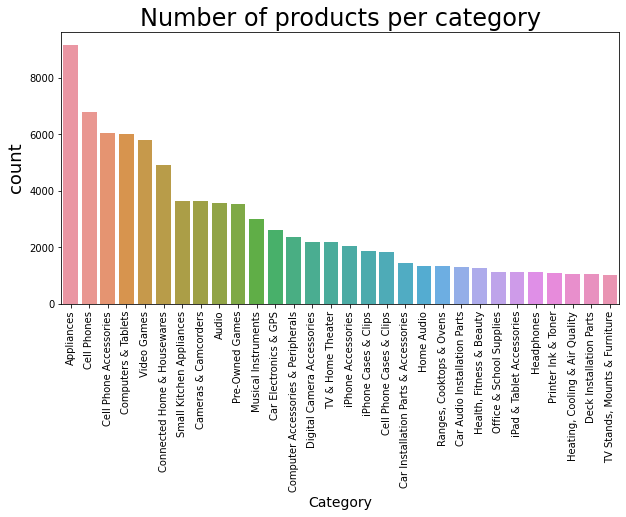

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(labels_count_filted['label'], labels_count_filted['count'])
plt.title("Number of products per category", fontsize=24)
plt.ylabel('count', fontsize=18)
plt.xlabel('Category', fontsize=14)
plt.xticks(rotation='vertical')

plt.show()

## Labels selection:

We reduced the number of categories by using the filter value. So all those categories having an occurrence count of less than the filter value will be considered as other categories.

In [ ]:
L = labels_count_filted['label'].values
L = np.append(L,'other_categories')
other = []
labels_encoding['other_categories'] = 0

for i in labels_encoding.columns:
    if i not in L:
        labels_encoding['other_categories'][labels_encoding[i] == 1] = 1
        other.append(i)

labels_encoding.drop(other, axis=1, inplace=True)

In [ ]:
len(other)

1772

In [ ]:
labels_encoding.shape

(50965, 31)

In [ ]:
labels_encoding.head()

,Appliances,Audio,Cameras & Camcorders,Car Audio Installation Parts,Car Electronics & GPS,Car Installation Parts & Accessories,Cell Phone Accessories,Cell Phone Cases & Clips,Cell Phones,Computer Accessories & Peripherals,...,Printer Ink & Toner,"Ranges, Cooktops & Ovens",Small Kitchen Appliances,TV & Home Theater,"TV Stands, Mounts & Furniture",Video Games,iPad & Tablet Accessories,iPhone Accessories,iPhone Cases & Clips,other_categories
0,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
labels_encoding['other_categories'].sum()


43571

In [ ]:
y = labels_encoding

In [ ]:
y.shape

(50965, 31)

# Building the model

In [ ]:
X.shape

(50965, 40212)

In [ ]:
y.shape

(50965, 31)

In [ ]:
n = 10000

In [ ]:
# Split Dataset into Train and Text
X_train, X_test, y_train, y_test = train_test_split(X[:n][:], y[:n][:], test_size= 0.3, shuffle=True)

In [ ]:
print("X_train shape : ",X_train.shape)
print("X_test shape : ",X_test.shape)
print("y_train shape : ",y_train.shape)
print("y_test shape : ",y_test.shape)

X_train shape :  (7000, 40212)
X_test shape :  (3000, 40212)
y_train shape :  (7000, 31)
y_test shape :  (3000, 31)


[Comparison of Four Multi-Label Classification Methods](https://www.causeweb.org/usproc/sites/default/files/usclap/2019-1/Comparison%20of%20Four%20Multi-Label%20Classification%20Methods.pdf)

[OneVsRestClassifier](https://towardsdatascience.com/multi-class-classification-one-vs-all-one-vs-one-94daed32a87b)

OneVsRestClassifier - when we want to do multiclass or multilabel classification and it's strategy consists of fitting one classifier per class. For each classifier, the class is fitted against all the other classes. (This is pretty clear and it means that problem of multiclass/multilabel classification is broken down to multiple binary classification problems).

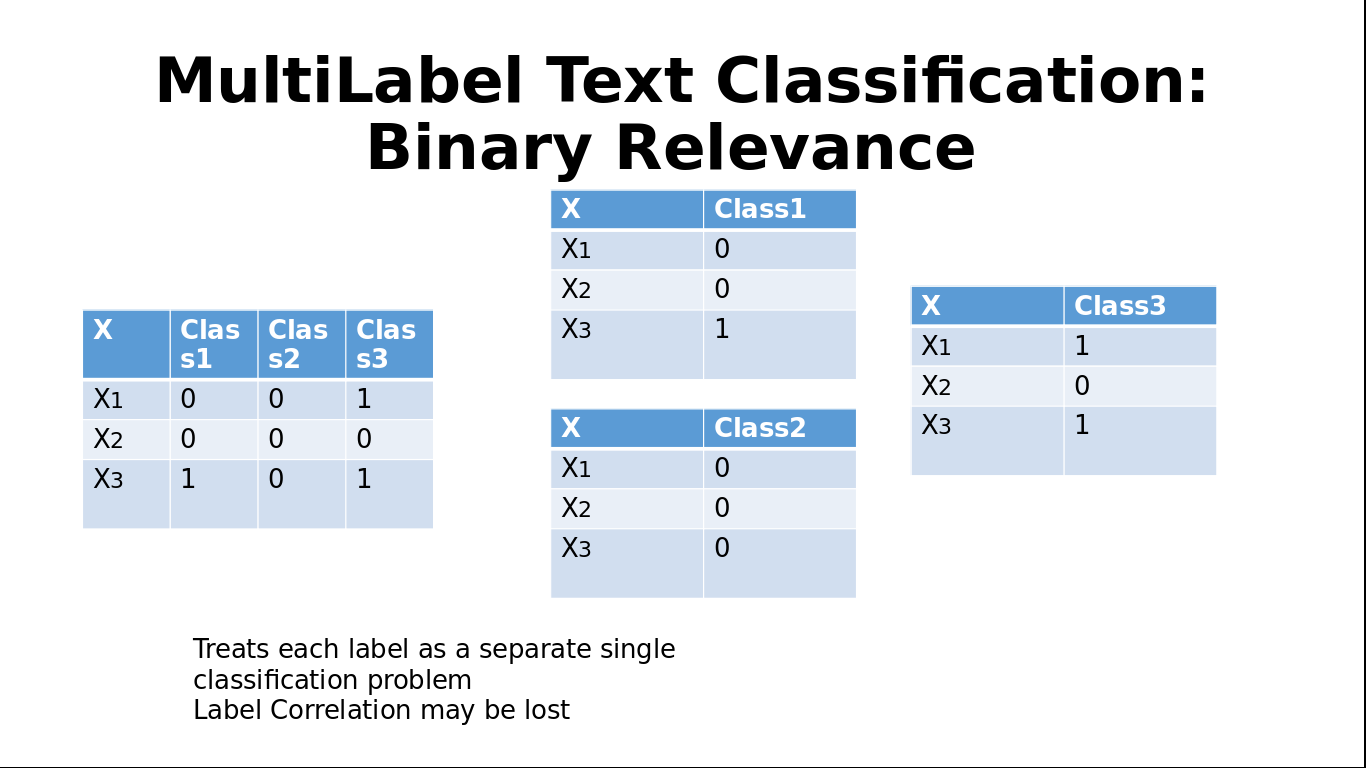

## Finding best model and hyper parameter tunning using *RandomizedSearchCV*


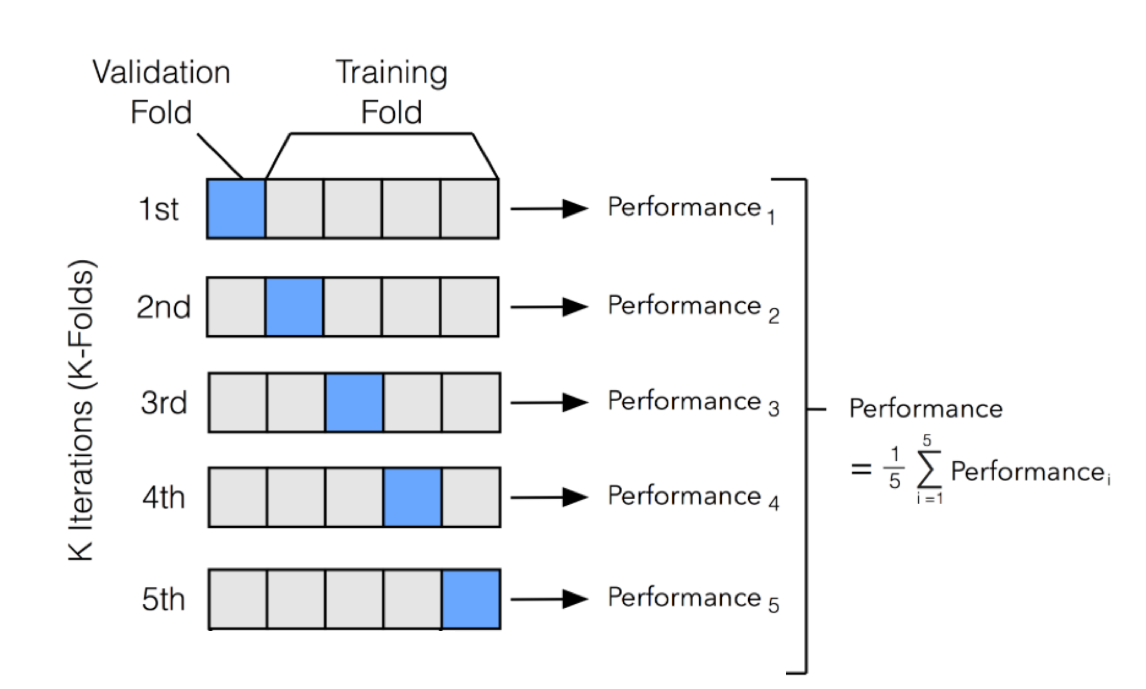

In [ ]:

model_params = {
    'svm': {
        'model':  OneVsRestClassifier(SVC()),
        'params' : {
            'estimator__C': [1,10,20],
            'estimator__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': OneVsRestClassifier(RandomForestClassifier()),
        'params' : {
            'estimator__n_estimators': [5,10,20],
            'estimator__max_depth': [5, 10, 15],
        }
    },

   
    'logistic_regression' : {
        'model': OneVsRestClassifier(LogisticRegression()),
        'params': {
            'estimator__C': [1,5,10]
        }
    }
}


[When to Use F1 Score vs. Accuracy](https://www.statology.org/f1-score-vs-accuracy/#:~:text=The%20F1%20score%20is%20a,downside%20to%20predicting%20false%20negatives.)

[Which average should I choose?](https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f)

In [ ]:

scores = []

for model_name, mp in model_params.items():
    print(mp['model'])
    clf =  RandomizedSearchCV(mp['model'], mp['params'],scoring ='f1_weighted', cv=5, n_iter=3) # scoring = 'f1_weighted'
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_model': clf.best_estimator_
    })
    print(clf.best_score_)

    
df = pd.DataFrame(scores,columns=['model','best_score','best_params','best_model'])
df = df.sort_values(by=['best_score'], ascending=False)
df

OneVsRestClassifier(estimator=SVC())
0.9249869074472576
OneVsRestClassifier(estimator=RandomForestClassifier())
0.4075223459098063
OneVsRestClassifier(estimator=LogisticRegression())
0.9179070624534713


,model,best_score,best_params,best_model
0,svm,0.924987,"{'estimator__kernel': 'rbf', 'estimator__C': 20}",OneVsRestClassifier(estimator=SVC(C=20))
2,logistic_regression,0.917907,{'estimator__C': 10},OneVsRestClassifier(estimator=LogisticRegressi...
1,random_forest,0.407522,"{'estimator__n_estimators': 5, 'estimator__max...",OneVsRestClassifier(estimator=RandomForestClas...


In [ ]:
df = df.sort_values(by=['best_score'], ascending=False)
df

,model,best_score,best_params,best_model
0,svm,0.924987,"{'estimator__kernel': 'rbf', 'estimator__C': 20}",OneVsRestClassifier(estimator=SVC(C=20))
2,logistic_regression,0.917907,{'estimator__C': 10},OneVsRestClassifier(estimator=LogisticRegressi...
1,random_forest,0.407522,"{'estimator__n_estimators': 5, 'estimator__max...",OneVsRestClassifier(estimator=RandomForestClas...


In [ ]:
best_model = df['best_model'][0]

In [ ]:
best_model

OneVsRestClassifier(estimator=SVC(C=20))

In [ ]:
y_pred = best_model.predict(X_test)

In [ ]:
f1_score(y_test, y_pred, average='micro')

0.9300340987869873

In [ ]:
hamming_loss(y_test,y_pred)

0.010419354838709677

## Save the model


We need to pickle or save your model so that we can quickly load the trained model into the API script.

In [ ]:
import joblib

In [ ]:
filename = "model.sav"
joblib.dump(best_model, filename)  

['model.sav']

#  API 

In [ ]:
# Api for category prediction
def Prediction(name,description):

    d = {'name': name, 'description': description}
    data = pd.DataFrame(data=d, index=[0])
    data = clean_text(data, 'name', 'name')
    data= clean_text(data, 'description', 'description')

    X = v.transform(data['name'] + data['description'])
    filename = "model.sav"
    model = joblib.load(filename) # loading already saved model


    # calculating test accuracy
    prediction = model.predict(X)
    L = list(prediction[0])

    for i, p in enumerate(L):
        if p ==1:
            label = list(labels_encoding.columns) 
            print(label[i])

    return prediction


In [ ]:
name = "Duracell - AAA Batteries (4-Pack)"
description = "Compatible with select electronic devices; AAA size; DURALOCK Power Preserve technology; 4-pack"
prediction = Prediction(name,description)

Connected Home & Housewares
other_categories


In [ ]:
name = "Samsung - Galaxy S7 32GB - Black Onyx (Sprint)"
description = "Qualcomm Snapdragon 820 MSM8996 2.2GHz quad-core processorAndroid 6.0 Marshmallow operating system4G mobile hotspot capability with support for up to 10 devicesWiFi Capable 802.11 a/b/g/n/ac5.1\" WQHD touch-screen displayBluetooth 4.2"
prediction = Prediction(name,description)

Cell Phones
other_categories


In [ ]:
name = "Motorola - Moto 360 2nd Generation Men's Smartwatch 42mm Stainless Steel - Gold Stainless Steel"
description = "Fits most wrist sizesCompatible with most Apple&#174; iOS and Android cell phones22mm stainless steel bandWater-resistant designAt-a-glance notifications"
prediction = Prediction(name,description)

Cell Phone Accessories
Cell Phones
other_categories


# Deploy the model

[ColabCode: Deploying Machine Learning Models From Google Colab](https://towardsdatascience.com/colabcode-deploying-machine-learning-models-from-google-colab-54e0d37a7b09)

[Deploy ML Models from Colab](https://www.youtube.com/watch?v=7-igAakUUTY)

[Deploy Your Machine Learning Model as a REST API](https://http://sparida.blogspot.com/2019/11/deploy-your-machine-learning-model-as.html)

In [ ]:
!pip install colabcode
!pip install fastapi

     |████████████████████████████████| 45 kB 1.5 MB/s 
     |████████████████████████████████| 8.3 MB 9.4 MB/s 
     |████████████████████████████████| 745 kB 36.8 MB/s 
     |████████████████████████████████| 343 kB 37.8 MB/s 
     |████████████████████████████████| 428 kB 45.8 MB/s 
     |████████████████████████████████| 53 kB 1.5 MB/s 
     |████████████████████████████████| 58 kB 4.5 MB/s 
     |████████████████████████████████| 561 kB 18.4 MB/s 
     |████████████████████████████████| 79 kB 6.2 MB/s 
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 130 kB 49.4 MB/s 
     |████████████████████████████████| 130 kB 37.4 MB/s 
     |████████████████████████████████| 130 kB 55.9 MB/s 
     |████████████████████████████████| 130 kB 58.1 MB/s 
     |████████████████████████████████| 130 kB 51.4 MB/s 
     |████████████████████████████████| 129 kB 43.0 MB/s 
     |████████████████████████████████| 125 kB 50.8 MB/s 
     |███████████████████

     |████████████████████████████████| 54 kB 1.5 MB/s 
     |████████████████████████████████| 58 kB 4.9 MB/s 
     |████████████████████████████████| 10.9 MB 42.8 MB/s 


In [ ]:
from colabcode import ColabCode
from fastapi import FastAPI

In [ ]:
cc = ColabCode(port=12000, code=False)

In [ ]:
app = FastAPI()

@app.get("/")
async def read_root():
  return {"message": "Hello"}

In [ ]:
cc.run_app(app=app)

Public URL: NgrokTunnel: "https://8f73-34-139-83-148.ngrok.io" -> "http://localhost:12000"


INFO:     Started server process [61]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:12000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [61]


In [ ]:
import pickle


Pkl_Filename = "model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

In [ ]:
import pickle
import logging
from fastapi import FastAPI

app = FastAPI(title="ML Models as API on Google Colab", description="with FastAPI and ColabCode", version="1.0")

# # Initialize logging
# my_logger = logging.getLogger()
# my_logger.setLevel(logging.DEBUG)
# logging.basicConfig(level=logging.DEBUG, filename='logs.log')

model = None

@app.on_event("startup")
def load_model():
    global model
    model = pickle.load(open("model.pkl", "rb"))

@app.post("/api", tags=["prediction"])
def Prediction(name,description):

    d = {'name': name, 'description': description}
    data = pd.DataFrame(data=d, index=[0])
    data = clean_text(data, 'name', 'name')
    data= clean_text(data, 'description', 'description')

    X = v.transform(data['name'] + data['description'])
    filename = "model.sav"
    model = joblib.load(filename) # loading already saved model


    # calculating test accuracy
    prediction = model.predict(X)
    L = list(prediction[0])

    for i, p in enumerate(L):
        if p ==1:
            label = list(labels_encoding.columns) 
            print(label[i])

    return prediction
